In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import matplotlib.pyplot as plt
import os

from models import LocallyWeightedCNP, CNP, ProMP,rbf

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

print(device.type)

# ---

torch.manual_seed(42)
np.random.seed(42)
#device = torch.device("cpu")

os.makedirs('out', exist_ok=True)

cuda


Training set shapes:  (80, 200) (80, 200)
Validation set shapes:  (20, 200) (20, 200)
torch.Size([80, 200, 1])
torch.Size([80, 200, 1])
torch.Size([20, 200, 1])
torch.Size([20, 200, 1])


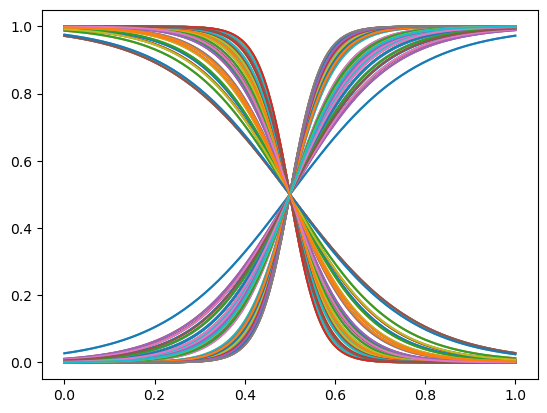

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def plot(data):
    x = torch.linspace(0, 1, data.shape[1])
    for traj in data:
        plt.plot(x, traj)

def cx_sigm(n=1, t_max=200):
    # rand_btw_7-30 * {-1, 1}
    c1 =(torch.rand(n, 1) * 23 + 7) * torch.from_numpy(np.random.choice([-1, 1], (n, 1)))  # c1 for steepness
    t = torch.linspace(0, 1, t_max)
    c2 = 0.5  # c2 midpoint
    
    data = 1/(1 + torch.exp(-c1 * (t-c2)))
    return data


n = 101
t_max = 200

data = cx_sigm(n, t_max).view(n, t_max, 1)#.to(device)
y_test = data[-1]

x_train, x_val, y_train, y_val = train_test_split(torch.linspace(0, 1, t_max).repeat(n-1, 1).
                                                  view(n-1, t_max, 1), data[:-1], train_size=0.8)



# Convert the PyTorch tensors to NumPy arrays and reshape them for ProMP
x_train_np = x_train.numpy().reshape(x_train.shape[0], -1)  # Flatten the x_train
y_train_np = y_train.numpy().reshape(y_train.shape[0], -1)  # Flatten the y_train
x_val_np = x_val.numpy().reshape(x_val.shape[0], -1)        # Flatten the x_val
y_val_np = y_val.numpy().reshape(y_val.shape[0], -1)        # Flatten the y_val

# Print out the shapes of the numpy arrays
print("Training set shapes: ", x_train_np.shape, y_train_np.shape)
print("Validation set shapes: ", x_val_np.shape, y_val_np.shape)

# Plot the data (if you want to plot using the original tensor format)
plot(data)  # You should modify the plot function to work with numpy if needed

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
plot(data.cpu())

In [4]:
# Initialize the ProMP model with appropriate dimensions.
promp_model = ProMP(n_dims=1, n_basis=10, kernel_range=(0, 1), kernel_width=None, amp=1.0, y_std=1e-4, prior_width=1.0)
# Training
print("Training started...")
promp_model.learn_from_demonstrations(x_train_np, y_train_np)
print("Training completed.")

Training started...
Training completed.


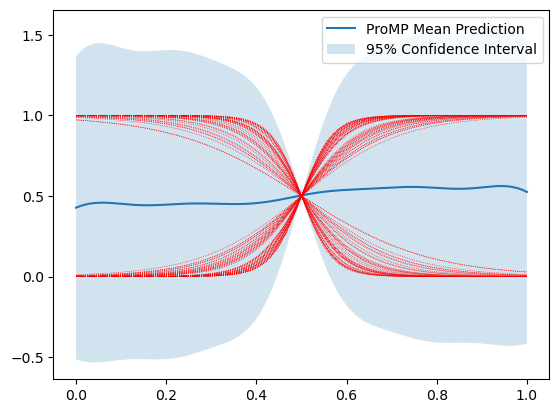

In [5]:

# After training, to see how the model fits the training data
t_query = np.linspace(0, 1, t_max).reshape(-1, 1)
predicted_means, predicted_stddevs = promp_model.query(t_query)

# Plot the mean predictions
plt.plot(t_query, predicted_means, label='ProMP Mean Prediction')

# Plot the confidence interval around the predictions
plt.fill_between(t_query.ravel(),
                 predicted_means.ravel() - 1.96 * predicted_stddevs.ravel(),
                 predicted_means.ravel() + 1.96 * predicted_stddevs.ravel(),
                 alpha=0.2, label='95% Confidence Interval')

# Optionally, plot the training data to see how it fits
for i in range(y_train_np.shape[0]):
    plt.plot(t_query, y_train_np[i, :], 'r:', linewidth=0.5)

plt.legend()
plt.show()

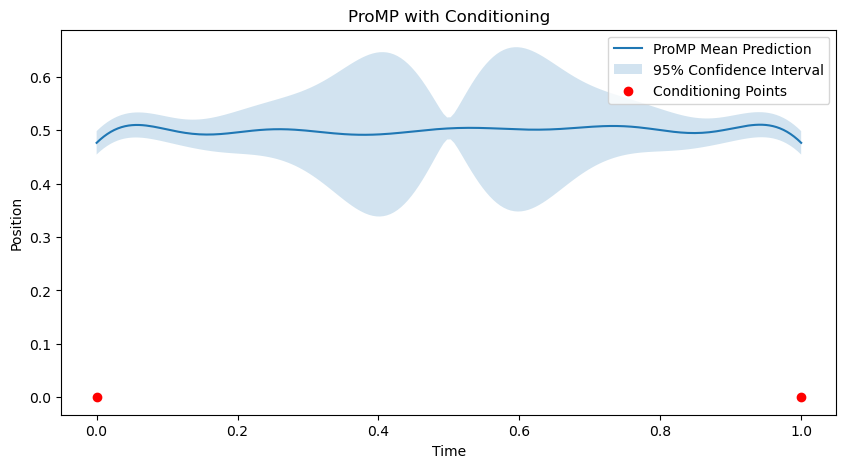

In [7]:
# Step 1: Create the conditioning points
# We want to condition such that the trajectory starts at 0 and ends at 1, so we take the first and last time points
condition_points_x = np.array([0, 1]).reshape(-1, 1)  # two time points
condition_points_y = np.array([0, 0]).reshape(-1, 1)  # corresponding positions

# Step 2: Condition the ProMP with these points
promp_model.condition(condition_points_x, condition_points_y)

# Step 3: Query the ProMP for the remaining points
# Let's get predictions for the entire range for plotting
t_query = np.linspace(0, 1, t_max).reshape(-1, 1)
predicted_means, predicted_stddevs = promp_model.query(t_query)

# Step 4: Plot the results
plt.figure(figsize=(10, 5))
plt.plot(t_query, predicted_means, label='ProMP Mean Prediction')

# Plot the confidence interval around the predictions
plt.fill_between(t_query.ravel(),
                 predicted_means.ravel() - 1.96 * predicted_stddevs.ravel(),
                 predicted_means.ravel() + 1.96 * predicted_stddevs.ravel(),
                 alpha=0.2, label='95% Confidence Interval')

# Plot conditioning points
plt.scatter(condition_points_x, condition_points_y, color='red', zorder=5, label='Conditioning Points')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('ProMP with Conditioning')
plt.show()

In [14]:
n_max = 10
num_trajs, t_steps = x_train.shape[0], x_train.shape[1]
d_x, d_y = x_train.shape[-1], y_train.shape[-1]

model = LocallyWeightedCNP((d_x, d_y),128,4,min_std=0.0001).to(device)


# Loading the model weights
#model.load_state_dict(torch.load('cnmp_best_validation.h5'))


learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def predict_model(observations, x_target, plot=True, step=-1):    
    with torch.no_grad():
        y_pred, std_pred = model(observations, x_target)
    
    if plot:
        for i in range(d_y):  # for every feature in Y vector we are plotting training data and its prediction
            fig = plt.figure(figsize=(5,5))
            for j in range(num_trajs):
                plt.plot(x_train[j, :, 0].cpu(), y_train[j, :, i].cpu(), c="b", alpha=0.1)

            idx = 0
            plt.plot(x_val[idx, :, 0].cpu(), y_pred[idx, :, i].cpu(), color='black')
            plt.errorbar(x_val[idx, :, 0].cpu(), y_pred[idx, :, i].cpu(), yerr=std_pred[idx, :, i].cpu(), color = 'black', alpha=0.4)
            plt.scatter(observations[idx, [0, -1], 0].cpu(), observations[idx, [0, -1], d_x+i].cpu(), marker="X", color='black')
            plt.savefig(f'out/{step}_{i}_val.png')
            plt.close()
    return y_pred, std_pred


def get_training_sample(batch_size=1, context_max=2, target_max=198):
    context_all = []
    target_all = []
    context_mask = []
    target_mask = []
    for _ in range(batch_size):
        n_context = torch.randint(1, context_max, ())
        n_target = torch.randint(1, target_max, ())
        traj_id = np.random.choice(num_trajs)
        traj_xdims = x_train[traj_id]
        traj_ydims = y_train[traj_id]
        R = torch.randperm(traj_xdims.shape[0])
        traj_xy = torch.cat([traj_xdims, traj_ydims], dim=-1)
        context = traj_xy[R[:n_context]]
        target = traj_xy[R[:(n_context+n_target)]]
        context_all.append(context)
        context_mask.append(torch.ones(context.shape[0]))
        target_all.append(target)
        target_mask.append(torch.ones(target.shape[0]))
    context_all = pad_sequence(context_all, batch_first=True)
    target_all = pad_sequence(target_all, batch_first=True)
    context_mask = pad_sequence(context_mask, batch_first=True)
    target_mask = pad_sequence(target_mask, batch_first=True)
    return context_all, target_all, context_mask, target_mask

In [15]:
smooth_losses = [0]
losses = []
loss_checkpoint = 1000
loss_inform_checkpoint = 100000
plot_checkpoint = 10000
validation_checkpoint = 1000
validation_error = 9999999

val_observation = torch.zeros(2, 1, d_x+d_y, device=device)
nof_val_trajs = x_val.shape[0]

for step in range(5000000):
    x_t, y_t, x_m, y_m = get_training_sample(1)

    optimizer.zero_grad()
    loss = model.nll_loss(x_t, y_t[..., :1], y_t[..., 1:])
    loss.backward()
    optimizer.step()
    
    if step % loss_inform_checkpoint == 0:
        print(f'Step: {step}')
    
    if step % loss_checkpoint == 0:
        losses.append(loss.data.cpu())
        smooth_losses[-1] += loss.data.cpu()/(plot_checkpoint/loss_checkpoint)
    
    if step % validation_checkpoint == 0:
        xy_val = torch.cat([x_val, y_val], dim=-1)
        current_error = model.nll_loss(xy_val[:, [0, -1]], x_val, y_val)  # only give the initial and the last timestep
        if current_error < validation_error:
            validation_error = current_error
            torch.save(model.state_dict(), 'trained_models/cnmp_best_validation_new.h5')
            print(f'Step: {step}. New validation best. Error: {current_error}')
        
    if step % plot_checkpoint == 0:        
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        plt.title('Train Loss')
        plt.plot(range(len(losses)),losses)
        plt.subplot(122)
        plt.title('Train Loss (Smoothed)')
        plt.plot(range(len(smooth_losses)), smooth_losses)
        plt.savefig(f'out/{step}.png')
        plt.close()
        
        #plotting validation cases
        predict_model(torch.tensor([[[0.0, 1.0], [1.0, 0.0]]]).to(device), x_val[:1], plot=True, step=step)
        predict_model(torch.tensor([[[0.0, 0.0], [1.0, 1.0]]]).to(device), x_val[:1], plot=True, step=step+1)
        predict_model(torch.tensor([[[0.0, 1.0], [1.0, 1.0]]]).to(device), x_val[:1], plot=True, step=step+2)
        predict_model(torch.tensor([[[0.0, 0.0], [1.0, 0.0]]]).to(device), x_val[:1], plot=True, step=step+3)
        
        if step!=0:
            smooth_losses.append(0)
# print('Finished Training')

Step: 0
Step: 0. New validation best. Error: 0.9300413131713867
Step: 1000. New validation best. Error: 0.22871607542037964
Step: 2000. New validation best. Error: -0.06914447247982025
Step: 3000. New validation best. Error: -0.3278709948062897
Step: 4000. New validation best. Error: -0.374627947807312
Step: 5000. New validation best. Error: -0.8887633681297302
Step: 7000. New validation best. Error: -1.2280755043029785
Step: 8000. New validation best. Error: -1.2578564882278442
Step: 10000. New validation best. Error: -1.5238546133041382
Step: 15000. New validation best. Error: -1.6516923904418945
Step: 23000. New validation best. Error: -1.778018832206726
Step: 33000. New validation best. Error: -1.829514741897583
Step: 66000. New validation best. Error: -1.9273179769515991
Step: 67000. New validation best. Error: -2.022972345352173
Step: 79000. New validation best. Error: -2.041407585144043
Step: 100000
Step: 110000. New validation best. Error: -2.1594693660736084
Step: 111000. New 

KeyboardInterrupt: 